# Gen Niche List

In [21]:
import pandas as pd
from pytrends.request import TrendReq
# need to modify this to recursivly parse the outputs down the json tree


def gen_niche_list():
    pytrends = TrendReq(hl='en-US')
    json_response = pytrends.categories()
    data = json_response['children']
    prefix = 'metadata_'
    df = pd.json_normalize(data, 'children', ['name', 'id'], record_prefix=prefix)
    metadata_cols = [col for col in df.columns if col.startswith(prefix)]
    df = pd.concat([df[['name', 'id']], df[metadata_cols].apply(pd.Series)], axis=1)
    df = df.explode("metadata_children").reset_index(drop=True)
    df = pd.concat([df.drop(["metadata_children"], axis=1), df["metadata_children"].apply(pd.Series)], axis=1)
    
    # Remove completely NaN columns
    df = df.dropna(axis=1, how='all')


    # Column cleaning operations

    columns = df.columns.tolist()
    
    # Rename first "name" column to "parent_category"
    columns[0] = 'parent_cat_desc'
    columns[1] = 'parent_cat_id'
    
    df.columns = columns


    # Column dtype setting
    
    df['id'] = df['id'].astype('Int64')

    # Explode the final childrens column

    df = df.explode("children").reset_index(drop=True)
    df = pd.concat([df.drop(["children"], axis=1), df["children"].apply(pd.Series)], axis=1)


    # Remove completely NaN columns
    df = df.dropna(axis=1, how='all')


    # Column cleaning operations part 2 lol

    columns_2 = df.columns.tolist()
    
    # Rename first "name" column to "parent_category"
    columns_2[4] = 'sub_cat_level_1'
    columns_2[5] = 'sub_cat_level_1_id'
    columns_2[6] = 'sub_cat_level_2'
    columns_2[7] = 'sub_cat_level_2_id'
    
    df.columns = columns_2


    # Explode the final childrens column

    df = df.explode("children").reset_index(drop=True)
    df = pd.concat([df.drop(["children"], axis=1), df["children"].apply(pd.Series)], axis=1)


    # Remove completely NaN columns
    df = df.dropna(axis=1, how='all')


    # Column cleaning operations part 2 lol

    columns_3 = df.columns.tolist()
    
    # Rename first "name" column to "parent_category"
    columns_3[8] = 'sub_cat_level_3'
    columns_3[9] = 'sub_cat_level_3_id'

    df.columns = columns_3


    df = df.explode("children").reset_index(drop=True)
    df = pd.concat([df.drop(["children"], axis=1), df["children"].apply(pd.Series)], axis=1)

        # Remove completely NaN columns
    df = df.dropna(axis=1, how='all')

    columns_4 = df.columns.tolist()
    
    # Rename first "name" column to "parent_category"
    columns_4[10] = 'sub_cat_level_4'
    columns_4[11] = 'sub_cat_level_4_id'

    df.columns = columns_4

    df['sub_cat_level_2_id'] = df['sub_cat_level_2_id'].astype('Int64')
    df['sub_cat_level_3_id'] = df['sub_cat_level_3_id'].astype('Int64')
    df['sub_cat_level_4_id'] = df['sub_cat_level_4_id'].astype('Int64')

    df = df.fillna(pd.NA)

    # Define a list of all subcategory columns
    subcategory_columns = ['sub_cat_level_1', 'sub_cat_level_2', 'sub_cat_level_3', 'sub_cat_level_4','parent_cat_desc']
    subcategory_columns_id = ['sub_cat_level_1_id', 'sub_cat_level_2_id', 'sub_cat_level_3_id', 'sub_cat_level_4_id','parent_cat_id']

    # Coalesce the subcategory columns into a single column containing only the first non-null value
    df['niche_desc'] = df[subcategory_columns].apply(lambda x: x.dropna().iloc[0], axis=1)
    df['niche_id'] = df[subcategory_columns_id].apply(lambda x: x.dropna().iloc[0], axis=1)

    df = df.drop(columns=['sub_cat_level_1', 'sub_cat_level_2', 'sub_cat_level_3', 'sub_cat_level_4','parent_cat_desc'])
    df = df.drop(columns=['sub_cat_level_1_id', 'sub_cat_level_2_id', 'sub_cat_level_3_id', 'sub_cat_level_4_id','parent_cat_id'])
    df = df.drop(columns=['metadata_name', 'metadata_id'])

    return df

# Gen Top News Content

In [22]:
import pandas as pd
from GoogleNews import GoogleNews
from newspaper import Article, Config, ArticleException

def fetch_top_stories(keyword, n):
    # initialize GoogleNews object
    googlenews = GoogleNews()
    googlenews.set_lang('en')
    
    # search for top news related to the keyword
    googlenews.search(keyword)
    
    # get URLs of top n stories
    links = googlenews.get_links()[:n]
    
    # initialize list to store dataframes
    df_list = []
    
    # loop through URLs
    for url in links:
        # initialize Article object with custom configuration
        config = Config()
        config.browser_user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        article = Article(url, config=config)
        
        try:
            article.download()
            article.parse()
            
            # check if summary is available
            if article.summary:
                summary = article.summary
            else:
                summary = None
            
            # create dataframe with metadata and content
            df = pd.DataFrame({
                'title': [article.title],
                'authors': [article.authors],
                'publish_date': [article.publish_date],
                'summary': [summary],
                'content': [article.text],
                'error': [None]
            })
            
        except ArticleException as e:
            print(f"Article {url} failed with error: {e}")
            # create dataframe with error message
            df = pd.DataFrame({
                'title': [None],
                'authors': [None],
                'publish_date': [None],
                'summary': [None],
                'content': [None],
                'error': [f"Article {url} failed with error: {e}"]
            })
            
        # add dataframe to list
        df_list.append(df)
    
    # concatenate dataframes
    result_df = pd.concat(df_list, ignore_index=True)
    
    return result_df


In [23]:
def build_short_text_prompt(title, content):
    """
    Builds a string using the given title and content.
    """
    import re

    input_string = f"{title} {content}"
    
    # Replace all line breaks, carriage returns, and other non-alphanumeric characters with a space
    cleaned_string = re.sub(r'[\n\r\W]+', ' ', input_string)
    
    # Remove any leading or trailing whitespace
    cleaned_string = cleaned_string.strip()

    return cleaned_string

In [69]:
import openai
import os

openai.api_key = os.environ['open_ai_key']

def generate_completion(prompt):
    """
    Generates a text completion for the given prompt using the OpenAI API.
    
    Args:
        prompt (str): The prompt to generate a completion for.
    
    Returns:
        str: The generated text completion.
    """
    # Set up the API parameters
    model_engine = "text-davinci-003"  # Replace with your desired language model
    max_tokens = 25  # Maximum number of tokens to generate
    n = 1  # Number of completions to generate
    stop_sequence = '-'  # Sequence to stop generation at
    
    # Generate the completion using the OpenAI API
    response = openai.Completion.create(
        model=model_engine,
        prompt=prompt,
        max_tokens=max_tokens,
        n=n,
        stop=stop_sequence
    )
    
    # Retrieve the generated completion
    completion = response.choices[0].text.strip()
    
    return completion

In [62]:
shorts_prompt = build_short_text_prompt(
    title = top_stories_df['title'][1],
    content = top_stories_df['content'][1]
    )

In [70]:
shorts_text_candidate = generate_completion(
    prompt = shorts_prompt
)

# Channel Names Gen

In [13]:
import openai
import os

openai.api_key = os.environ['open_ai_key']

def generate_completion(prompt):
    """
    Generates a text completion for the given prompt using the OpenAI API.
    
    Args:
        prompt (str): The prompt to generate a completion for.
    
    Returns:
        str: The generated text completion.
    """
    # Set up the API parameters
    model_engine = "text-davinci-003"  # Replace with your desired language model
    max_tokens = 25  # Maximum number of tokens to generate
    n = 1  # Number of completions to generate
    stop_sequence = '-'  # Sequence to stop generation at
    
    # Generate the completion using the OpenAI API
    response = openai.Completion.create(
        model=model_engine,
        prompt=prompt,
        max_tokens=max_tokens,
        n=n,
        stop=stop_sequence
    )
    
    # Retrieve the generated completion
    completion = response.choices[0].text.strip()
    
    return completion

In [19]:
youtube_test_name

'MangaVibes'

# Channel Photo Gen

In [7]:
import openai
import os
import requests
from PIL import Image
from io import BytesIO


##### need to add a way to create either 
# a profile pic It’s recommended to use a picture that’s at least 98 x 98 pixels and 4MB or less. Use a PNG or GIF (no animations) file. Make sure your picture follows the YouTube Community Guidelines. 
# a Banner image For the best results on all devices, use an image that’s at least 2048 x 1152 pixels and 6MB or less
# a water mark Video watermark An image that’s 150 x 150 pixels is recommended. Use a PNG, GIF (no animations), BMP, or JPEG file that’s 1MB or less.



# for banner could concatnate images or trim them

# from PIL import Image

# # Open the two images
# image1 = Image.open("image1.png")
# image2 = Image.open("image2.png")

# # Get the dimensions of the images
# width1, height1 = image1.size
# width2, height2 = image2.size

# # Create a new image with the required dimensions
# new_image = Image.new('RGB', (width1 + width2, max(height1, height2)))

# # Paste the images into the new image
# new_image.paste(image1, (0, 0))
# new_image.paste(image2, (width1, 0))

# # Save the new image
# new_image.save("concatenated_image.png")

openai.api_key = os.environ['open_ai_key']

def generate_channel_image(niche, channel_name, image_type=None):
    """
    Generates an image for the given prompt using the OpenAI API.

    Args:
        prompt (str): The prompt to generate an image for.

    Returns:
        str: The filename of the saved image.
    """
    # Set up the API parameters
    prompt_str = f"a trendy hip cryptic photo for a youtube channel which talks about {niche}"
    model = "image-alpha-001"  # Replace with your desired image model
    response_format = "url"  # Specify response format as URL


    # Generate the image using the OpenAI API
    response = openai.Image.create(
        prompt=prompt_str,
        model=model,
        response_format=response_format
    )

    # Fetch the image from the URL and save it as a JPEG file in the current directory
    response = requests.get(response["data"][0]["url"])
    image = Image.open(BytesIO(response.content))
    filename = f'{channel_name}.png'
    image.save(f'data/channel_photos/{filename}', format="PNG")

    return filename


In [12]:
import openai
import os
import requests
from PIL import Image


##### need to add a way to create either 
# a profile pic It’s recommended to use a picture that’s at least 98 x 98 pixels and 4MB or less. Use a PNG or GIF (no animations) file. Make sure your picture follows the YouTube Community Guidelines. 
# a Banner image For the best results on all devices, use an image that’s at least 2048 x 1152 pixels and 6MB or less
# a water mark Video watermark An image that’s 150 x 150 pixels is recommended. Use a PNG, GIF (no animations), BMP, or JPEG file that’s 1MB or less.



# for banner could concatnate images or trim them

# from PIL import Image

# # Open the two images
# image1 = Image.open("image1.png")
# image2 = Image.open("image2.png")

# # Get the dimensions of the images
# width1, height1 = image1.size
# width2, height2 = image2.size

# # Create a new image with the required dimensions
# new_image = Image.new('RGB', (width1 + width2, max(height1, height2)))

# # Paste the images into the new image
# new_image.paste(image1, (0, 0))
# new_image.paste(image2, (width1, 0))

# # Save the new image
# new_image.save("concatenated_image.png")

openai.api_key = os.environ['open_ai_key']

def generate_channel_water_mark(niche, channel_name, image_type=None):
    """
    Generates an image for the given prompt using the OpenAI API.

    Args:
        prompt (str): The prompt to generate an image for.

    Returns:
        str: The filename of the saved image.
    """
    # Set up the API parameters
    prompt_str = f"a trendy hip cryptic photo for a youtube channel watermark resembling {niche}"
    model = "image-alpha-001"  # Replace with your desired image model
    response_format = "url"  # Specify response format as URL


    # Generate the image using the OpenAI API
    response = openai.Image.create(
        prompt=prompt_str,
        model=model,
        response_format=response_format
    )

    # Fetch the image from the URL and save it as a JPEG file in the current directory
    response = requests.get(response["data"][0]["url"])
    image = Image.open(BytesIO(response.content))
    filename = f'{channel_name}.png'
    image.save(f'data/channel_photos/watermark{filename}', format="PNG")

    return filename


In [79]:
niche_str = 'Anime & Manga'
channel_name_str = 'MangaVibes'
youtube_test_image = generate_channel_image(niche=niche_str, channel_name=channel_name_str)

In [13]:
niche_str = 'Anime & Manga'
channel_name_str = 'MangaVibes'
youtube_test_image = generate_channel_water_mark(niche=niche_str, channel_name=channel_name_str)

In [3]:
import io
import os
from PIL import Image


def compress_png_image(image_path, quality=70, resize_width=None):
    """
    Compresses an image in PNG format and writes the compressed image to the same file path.

    Args:
        image_path (str): Path to the image file.
        quality (int): Quality of the compressed image (0-100). Default is 70.
        resize_width (int): Width to resize the image to before compression. Default is None.
    """
    # Open the image file.
    with open(image_path, 'rb') as f:
        image = Image.open(f)

        # Resize the image if a width is specified.
        if resize_width is not None:
            wpercent = (resize_width/float(image.size[0]))
            hsize = int((float(image.size[1])*float(wpercent)))
            image = image.resize((resize_width, hsize), Image.ANTIALIAS)

        # Compress the image.
        with io.BytesIO() as output:
            if os.path.splitext(image_path)[1].lower() == '.png':
                image = image.convert('RGB')
            image.save(output, format='JPEG', quality=quality)
            compressed_image = output.getvalue()

    # Write the compressed image back to the same file path.
    with open(image_path, 'wb') as f:
        f.write(compressed_image)


In [5]:
compress_png_image('/workspace/automated-shorts/src/data/channel_photos/watermarkMangaVibes.png', quality=20, resize_width=50)

/tmp/ipykernel_1534/2934283126.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((resize_width, hsize), Image.ANTIALIAS)


# Example outputs

In [69]:
niche_df = gen_niche_list()

In [70]:
top_stories_df = fetch_top_stories(keyword=niche_df['niche_desc'][2], n=5)

In [71]:
niche_df

,niche_desc,niche_id
0,Arts & Entertainment,3
1,Animated Films,1104
2,Anime & Manga,317
3,Cartoons,319
4,Comics,318
...,...,...
1065,Theme Parks,1008
1066,Zoos-Aquariums-Preserves,1009
1067,Tourist Boards & Visitor Centers,1392
1068,Vacation Offers,1019


In [72]:
top_stories_df

,title,authors,publish_date,summary,content,error
0,Legendary Japanese manga and anime creator Lei...,[Mary Sushma],2023-02-22 00:00:00,None,"At the age of 85, Leiji Matsumoto, the creator...",None
1,10 Anime That Don't Need A Second Season,[Bailee Berta],2023-02-21 18:21:14+00:00,None,Anime is known for its long multi-season plot ...,None
2,My Clueless First Friend Anime Reveals April 9...,[Natalie Collins],2023-02-21 22:34:49+00:00,None,The official website for the My Clueless First...,None
3,Anime Adventure ‘Blue Thermal’ Coming Home Mar...,[],None,None,Shout! Factory and Eleven Arts have announced ...,None
4,Anime On Netflix For Beginners,[],None,None,Japanese anime (derived from the word “animati...,None


In [18]:
niche = 'Anime & Manga'
prompt_str = f"a trendy hip cryptic name for a youtube channel which talks about {niche} should be: "
youtube_test_name = generate_completion(prompt=prompt_str)

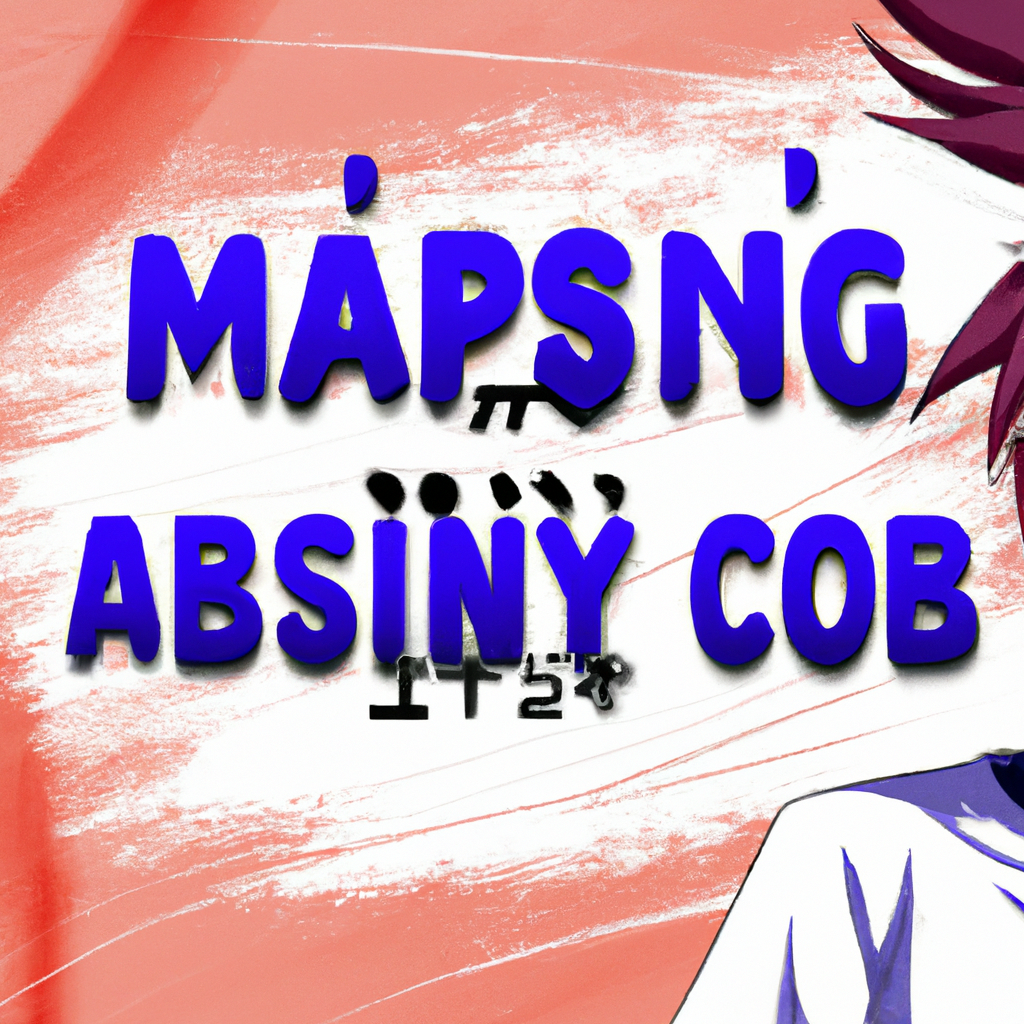

1.625457763671875


In [3]:
from IPython.display import Image, display
import os

# Set the path to the image
image_path = "/workspace/automated-shorts/src/data/channel_photos/MangaVibes.png"

# Display the image
display(Image(filename=image_path))

print(os.path.getsize(image_path) / (1024 * 1024))

# Gen Gmail account 

In [ ]:
import random
import string
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build


def generate_gmail_account(input_str: str) -> str:
    # manipulate input string to generate potential account names
    name, domain = input_str.split('@')
    name = name.lower()
    name = re.sub(r'[^\w\s]', '', name)  # remove non-alphanumeric characters
    name = re.sub(r'(\s)+', '.', name)  # replace whitespace with '.'
    name = ''.join(random.sample(name, len(name)))  # randomly shuffle characters

    # initialize Google API client
    credentials = Credentials.from_authorized_user_file('credentials.json')
    service = build('gmail', 'v1', credentials=credentials)

    # check availability of potential account names
    for i in range(100):
        potential_name = name + str(i) if i > 0 else name
        email = potential_name + '@' + domain
        try:
            response = service.users().getProfile(userId=email).execute()
        except:
            # account doesn't exist, return the potential name
            return email

    # all potential account names are taken
    return None


# start forwarding services

In [ ]:
from google.oauth2.credentials import Credentials
from googleapiclient.errors import HttpError
from googleapiclient.discovery import build


def start_forwarding(source_email: str, destination_email: str) -> bool:
    try:
        # authenticate and authorize with the Google API
        credentials = Credentials.from_authorized_user_file('source_credentials.json')
        service = build('gmail', 'v1', credentials=credentials)

        # configure forwarding settings for the source account
        forwarding_settings = {
            'enableForwarding': True,
            'forwardingEmail': destination_email
        }
        forwarding = service.users().settings().forwardingAddresses()
        forwarding.create(userId=source_email, body=forwarding_settings).execute()

        # verify that the forwarding settings have been configured correctly
        forwarding_settings = forwarding.get(userId=source_email, forwardingEmail=destination_email).execute()
        if forwarding_settings['verificationStatus'] == 'accepted':
            return True
        else:
            return False
    except HttpError as error:
        print(f'An error occurred: {error}')
        return False

In [ ]:
# gen a master account
# then create 1000 sub accounts
# forward all emails to master account